In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class CentralDifference:
    def __init__(self, dt, init_disp, init_R, k, m, c):
        self.dt = dt
        self.init_disp = init_disp
        self.k = k
        self.m = m
        self.c = c
        
        self.velocity = np.zeros(init_disp.shape)
        self.accel = np.matmul(init_R, inv(self.m))
        
        self.a0 = 1 / dt ** 2
        self.a1 = 1 / 2 * dt
        self.a2 = 2 * self.a0
        self.a3 = 1 / self.a2
        
        self.em = inv(self.a0 * m + self.a1 * self.c)
        
        self._get_last(init_disp)
        
    def solve(self, U, R):
        el = R - np.matmul((self.k - self.a2 * self.m), U) - np.matmul((self.a0 * self.m - self.a1 * self.c), self.last_pos)
        nU = np.matmul(self.em, el)
        self.accel = self.a0 * (self.last_pos - 2 * U + nU)
        self.velocity = self.a1 * ((-1 * self.last_pos) + nU)
        self.last_pos = U
        return nU
    
    def _get_last(self, pos):
        self.last_pos = pos - self.dt * self.velocity + self.a3 * self.accel
        

In [3]:
def raleigh_damping(k, m, mu, lambda_):
    return mu * m + lambda_ * k

In [4]:
def slice_by_rows_and_cols(v, rows, cols):
    out = np.zeros((len(rows), len(cols)))
    for i, row in enumerate(rows):
        for j, col in enumerate(cols):
            out[i, j] = v[row, col]
    return out

### Global Stiffness Approximations

#### Infinitessimal Strain Stiffness Approximation
This approximation is direct from the textbook for the infinitessimal strain model with a very-large E.

In [5]:
raw_infinitessimal_k = np.array([
     3.54627e+08, 4.20673e+06, 8.41346e+06,-2.35577e+08, 5.04808e+06, 1.00962e+07,     -168269, 3.36538e+06,           0,-1.17536e+08,-1.26202e+07, 1.68269e+06,     -673077,           0, 6.73077e+06,-1.18041e+08,      841346,-2.52404e+07, 1.17368e+08,     -841346,-1.68269e+06,           0,           0,           0,
 4.20673e+06, 1.02855e+08,      420673, 3.36538e+06,-6.73077e+07,           0, 5.04808e+06,     -588942,      504808,-1.26202e+07,-3.36118e+07,     84134.6,           0,     -673077,      336538,     -841346,-3.36959e+07,    -84134.6,      841346, 3.30228e+07,-1.26202e+06,           0,           0,           0,
 8.41346e+06,      420673, 1.04748e+08, 6.73077e+06,           0,-6.73077e+07,           0,      336538,     -168269,-1.68269e+06,    -84134.6,-3.25601e+07, 1.00962e+07,      504808,-2.35577e+06,-2.52404e+07,     84134.6,-3.47476e+07, 1.68269e+06,-1.26202e+06, 3.23918e+07,           0,           0,           0,
-2.35577e+08, 3.36538e+06, 6.73077e+06, 2.36418e+08,-8.41346e+06,-1.68269e+07,           0,           0,           0,     -168269, 5.04808e+06,           0,           0,           0,           0,     -673077,           0, 1.00962e+07,           0,           0,           0,           0,           0,           0,
 5.04808e+06,-6.73077e+07,           0,-8.41346e+06, 6.85697e+07,      841346,           0,           0,           0, 3.36538e+06,     -588942,     -336538,           0,           0,           0,           0,     -673077,     -504808,           0,           0,           0,           0,           0,           0,
 1.00962e+07,           0,-6.73077e+07,-1.68269e+07,      841346, 6.98317e+07,           0,           0,           0,           0,     -504808,     -168269,           0,           0,           0, 6.73077e+06,     -336538,-2.35577e+06,           0,           0,           0,           0,           0,           0,
     -168269, 5.04808e+06,           0,           0,           0,           0, 2.36418e+08,-8.41346e+06, 1.68269e+07,-2.35577e+08, 3.36538e+06,-6.73077e+06,           0,           0,           0,           0,           0,           0,     -673077,           0,-1.00962e+07,           0,           0,           0,
 3.36538e+06,     -588942,      336538,           0,           0,           0,-8.41346e+06, 6.85697e+07,     -841346, 5.04808e+06,-6.73077e+07,           0,           0,           0,           0,           0,           0,           0,           0,     -673077,      504808,           0,           0,           0,
           0,      504808,     -168269,           0,           0,           0, 1.68269e+07,     -841346, 6.98317e+07,-1.00962e+07,           0,-6.73077e+07,           0,           0,           0,           0,           0,           0,-6.73077e+06,      336538,-2.35577e+06,           0,           0,           0,
-1.17536e+08,-1.26202e+07,-1.68269e+06,     -168269, 3.36538e+06,           0,-2.35577e+08, 5.04808e+06,-1.00962e+07, 3.54627e+08, 4.20673e+06,-8.41346e+06,           0,           0,           0, 1.17368e+08,     -841346, 1.68269e+06,-1.18041e+08,      841346, 2.52404e+07,     -673077,           0,-6.73077e+06,
-1.26202e+07,-3.36118e+07,    -84134.6, 5.04808e+06,     -588942,     -504808, 3.36538e+06,-6.73077e+07,           0, 4.20673e+06, 1.02855e+08,     -420673,           0,           0,           0,      841346, 3.30228e+07, 1.26202e+06,     -841346,-3.36959e+07,     84134.6,           0,     -673077,     -336538,
 1.68269e+06,     84134.6,-3.25601e+07,           0,     -336538,     -168269,-6.73077e+06,           0,-6.73077e+07,-8.41346e+06,     -420673, 1.04748e+08,           0,           0,           0,-1.68269e+06, 1.26202e+06, 3.23918e+07, 2.52404e+07,    -84134.6,-3.47476e+07,-1.00962e+07,     -504808,-2.35577e+06,
     -673077,           0, 1.00962e+07,           0,           0,           0,           0,           0,           0,           0,           0,           0, 2.36418e+08, 8.41346e+06,-1.68269e+07,-2.35577e+08,-3.36538e+06, 6.73077e+06,     -168269,-5.04808e+06,           0,           0,           0,           0,
           0,     -673077,      504808,           0,           0,           0,           0,           0,           0,           0,           0,           0, 8.41346e+06, 6.85697e+07,     -841346,-5.04808e+06,-6.73077e+07,           0,-3.36538e+06,     -588942,      336538,           0,           0,           0,
 6.73077e+06,      336538,-2.35577e+06,           0,           0,           0,           0,           0,           0,           0,           0,           0,-1.68269e+07,     -841346, 6.98317e+07, 1.00962e+07,           0,-6.73077e+07,           0,      504808,     -168269,           0,           0,           0,
-1.18041e+08,     -841346,-2.52404e+07,     -673077,           0, 6.73077e+06,           0,           0,           0, 1.17368e+08,      841346,-1.68269e+06,-2.35577e+08,-5.04808e+06, 1.00962e+07, 3.54627e+08,-4.20673e+06, 8.41346e+06,-1.17536e+08, 1.26202e+07, 1.68269e+06,     -168269,-3.36538e+06,           0,
      841346,-3.36959e+07,     84134.6,           0,     -673077,     -336538,           0,           0,           0,     -841346, 3.30228e+07, 1.26202e+06,-3.36538e+06,-6.73077e+07,           0,-4.20673e+06, 1.02855e+08,     -420673, 1.26202e+07,-3.36118e+07,    -84134.6,-5.04808e+06,     -588942,     -504808,
-2.52404e+07,    -84134.6,-3.47476e+07, 1.00962e+07,     -504808,-2.35577e+06,           0,           0,           0, 1.68269e+06, 1.26202e+06, 3.23918e+07, 6.73077e+06,           0,-6.73077e+07, 8.41346e+06,     -420673, 1.04748e+08,-1.68269e+06,     84134.6,-3.25601e+07,           0,     -336538,     -168269,
 1.17368e+08,      841346, 1.68269e+06,           0,           0,           0,     -673077,           0,-6.73077e+06,-1.18041e+08,     -841346, 2.52404e+07,     -168269,-3.36538e+06,           0,-1.17536e+08, 1.26202e+07,-1.68269e+06, 3.54627e+08,-4.20673e+06,-8.41346e+06,-2.35577e+08,-5.04808e+06,-1.00962e+07,
     -841346, 3.30228e+07,-1.26202e+06,           0,           0,           0,           0,     -673077,      336538,      841346,-3.36959e+07,    -84134.6,-5.04808e+06,     -588942,      504808, 1.26202e+07,-3.36118e+07,     84134.6,-4.20673e+06, 1.02855e+08,      420673,-3.36538e+06,-6.73077e+07,           0,
-1.68269e+06,-1.26202e+06, 3.23918e+07,           0,           0,           0,-1.00962e+07,      504808,-2.35577e+06, 2.52404e+07,     84134.6,-3.47476e+07,           0,      336538,     -168269, 1.68269e+06,    -84134.6,-3.25601e+07,-8.41346e+06,      420673, 1.04748e+08,-6.73077e+06,           0,-6.73077e+07,
           0,           0,           0,           0,           0,           0,           0,           0,           0,     -673077,           0,-1.00962e+07,           0,           0,           0,     -168269,-5.04808e+06,           0,-2.35577e+08,-3.36538e+06,-6.73077e+06, 2.36418e+08, 8.41346e+06, 1.68269e+07,
           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,     -673077,     -504808,           0,           0,           0,-3.36538e+06,     -588942,     -336538,-5.04808e+06,-6.73077e+07,           0, 8.41346e+06, 6.85697e+07,      841346,
           0,           0,           0,           0,           0,           0,           0,           0,           0,-6.73077e+06,     -336538,-2.35577e+06,           0,           0,           0,           0,     -504808,     -168269,-1.00962e+07,           0,-6.73077e+07, 1.68269e+07,      841346, 6.98317e+07,

])
global_stiffness = raw_infinitessimal_k.reshape(24, 24)
indices = [i for i in range(6, 12)] + [i for i in range(18, 24)]


np.set_printoptions(precision=2, suppress=True)
K = slice_by_rows_and_cols(global_stiffness, indices, indices)
print(K/1e8)

[[ 2.36 -0.08  0.17 -2.36  0.03 -0.07 -0.01  0.   -0.1   0.    0.    0.  ]
 [-0.08  0.69 -0.01  0.05 -0.67  0.    0.   -0.01  0.01  0.    0.    0.  ]
 [ 0.17 -0.01  0.7  -0.1   0.   -0.67 -0.07  0.   -0.02  0.    0.    0.  ]
 [-2.36  0.05 -0.1   3.55  0.04 -0.08 -1.18  0.01  0.25 -0.01  0.   -0.07]
 [ 0.03 -0.67  0.    0.04  1.03 -0.   -0.01 -0.34  0.    0.   -0.01 -0.  ]
 [-0.07  0.   -0.67 -0.08 -0.    1.05  0.25 -0.   -0.35 -0.1  -0.01 -0.02]
 [-0.01  0.   -0.07 -1.18 -0.01  0.25  3.55 -0.04 -0.08 -2.36 -0.05 -0.1 ]
 [ 0.   -0.01  0.    0.01 -0.34 -0.   -0.04  1.03  0.   -0.03 -0.67  0.  ]
 [-0.1   0.01 -0.02  0.25  0.   -0.35 -0.08  0.    1.05 -0.07  0.   -0.67]
 [ 0.    0.    0.   -0.01  0.   -0.1  -2.36 -0.03 -0.07  2.36  0.08  0.17]
 [ 0.    0.    0.    0.   -0.01 -0.01 -0.05 -0.67  0.    0.08  0.69  0.01]
 [ 0.    0.    0.   -0.07 -0.   -0.02 -0.1   0.   -0.67  0.17  0.01  0.7 ]]


#### "Springy" Strain Stiffness Approximation

In [31]:
small_modulus_K = np.array([[961.539,0,0,-448.718,192.308,-192.308,-384.615,128.205,-128.205,128.205,-128.205,320.513],
[0,1282.05,-641.026,128.205,-128.205,0,192.308,-705.128,512.821,-192.308,448.718,-128.205],
[0,-641.026,1282.05,-128.205,0,-128.205,-192.308,448.718,-1025.64,320.513,-192.308,128.205],
[-448.718,128.205,-128.205,705.128,-320.513,320.513,0,0,0,-128.205,0,-192.308],
[192.308,-128.205,0,-320.513,705.128,-320.513,0,0,0,0,-128.205,192.308],
[-192.308,0,-128.205,320.513,-320.513,705.128,0,0,0,-128.205,128.205,-448.718],
[-384.615,192.308,-192.308,0,0,0,1538.46,-320.513,320.513,-1025.64,512.821,-128.205],
[128.205,-705.128,448.718,0,0,0,-320.513,1858.97,-320.513,448.718,-705.128,128.205],
[-128.205,512.821,-1025.64,0,0,0,320.513,-320.513,1538.46,-192.308,192.308,-384.615],
[128.205,-192.308,320.513,-128.205,0,-128.205,-1025.64,448.718,-192.308,1282.05,-641.026,0],
[-128.205,448.718,-192.308,0,-128.205,128.205,512.821,-705.128,192.308,-641.026,1282.05,0],
[320.513,-128.205,128.205,-192.308,192.308,-448.718,-128.205,128.205,-384.615,0,0,961.539],
])

small_modulus_K
# indices = [i for i in range(6, 12)] + [i for i in range(18, 24)]
# K = slice_by_rows_and_cols(small_modulus_K, indices, indices)
K = small_modulus_K
print(K * 10)

[[  9615.39      0.        0.    -4487.18   1923.08  -1923.08  -3846.15
    1282.05  -1282.05   1282.05  -1282.05   3205.13]
 [     0.    12820.5   -6410.26   1282.05  -1282.05      0.     1923.08
   -7051.28   5128.21  -1923.08   4487.18  -1282.05]
 [     0.    -6410.26  12820.5   -1282.05      0.    -1282.05  -1923.08
    4487.18 -10256.4    3205.13  -1923.08   1282.05]
 [ -4487.18   1282.05  -1282.05   7051.28  -3205.13   3205.13      0.
       0.        0.    -1282.05      0.    -1923.08]
 [  1923.08  -1282.05      0.    -3205.13   7051.28  -3205.13      0.
       0.        0.        0.    -1282.05   1923.08]
 [ -1923.08      0.    -1282.05   3205.13  -3205.13   7051.28      0.
       0.        0.    -1282.05   1282.05  -4487.18]
 [ -3846.15   1923.08  -1923.08      0.        0.        0.    15384.6
   -3205.13   3205.13 -10256.4    5128.21  -1282.05]
 [  1282.05  -7051.28   4487.18      0.        0.        0.    -3205.13
   18589.7   -3205.13   4487.18  -7051.28   1282.05]
 [ -128

### Static Explicit Central Difference Approximation
The static approximation of the explicit central difference time integrator setup is as follows, this code will be used to verify that my implementation is correct, the results match the Bathe FEA book, so I belive my implementation is right.

[0.   0.39]
[0.03 1.45]
[0.17 2.83]
[0.49 4.14]
[1.02 5.02]
[1.7  5.26]
[2.4 4.9]
[2.91 4.17]
[3.07 3.37]
[2.77 2.78]
[2.04 2.54]
[1.02 2.6 ]


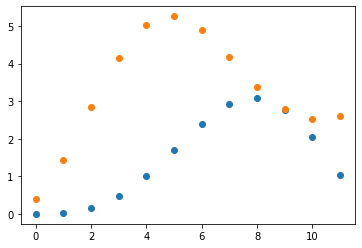

In [32]:
init_disp = np.array([0, 0])
init_R = np.array([0, 10])
k = np.array([[6, -2], [-2, 4]])
m = np.array([[2, 0], [0, 1]])
# To show damping, uncomment this.
# c = raleigh_damping(k, m, 0.6, 0.4)
c = np.array([[0, 0], [0, 0]])
cd = CentralDifference(0.28, init_disp, init_R, k, m, c)

U = np.array([0, 0])
R = np.array([0, 10])
results = []
n = 12
for i in range(n):
    U = cd.solve(U, R)
    print(U)
    results.append(U)
    
x = [i for i in range(n)]
    
results = np.array(results)
plt.scatter(x, results[:, 0])
plt.scatter(x, results[:, 1])
plt.show()

### Dynamic Infinitessimal Strain Approximation
Now we just need to roll the infinitessimal static model into the integrator to get the dynamic simulation working.

In [46]:
U = np.zeros(12)
R = np.array([
    0,
 -9.8,
    0,
    0,
 -9.8,
    0,
    0,
 -9.8,
    0,
    0,
 -9.8,
    0,
])
m = np.identity(12)
c = raleigh_damping(K, m, 0.5, 0.5)
cd = CentralDifference(0.01, U, R, K, m, c)

results = []
n = 1000
for i in range(n):
    results.append(U)
    U = cd.solve(U, R)

[[ 0.  0.  0. -0.  0. -0. -0.  0. -0.  0. -0.  0.]
 [ 0.  0. -0.  0. -0.  0.  0. -0.  0. -0.  0. -0.]
 [ 0. -0.  0. -0.  0. -0. -0.  0. -0.  0. -0.  0.]
 [-0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.]
 [ 0. -0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0.]
 [-0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.]
 [-0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0. -0.]
 [ 0. -0.  0.  0.  0.  0. -0.  0. -0.  0. -0.  0.]
 [-0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0. -0.]
 [ 0. -0.  0. -0.  0. -0. -0.  0. -0.  0. -0.  0.]
 [-0.  0. -0.  0. -0.  0.  0. -0.  0. -0.  0.  0.]
 [ 0. -0.  0. -0.  0. -0. -0.  0. -0.  0.  0.  0.]]


### Results
This experiment shows that the values explode without bound, never reaching oscillation unless the damping is unreasonably large.

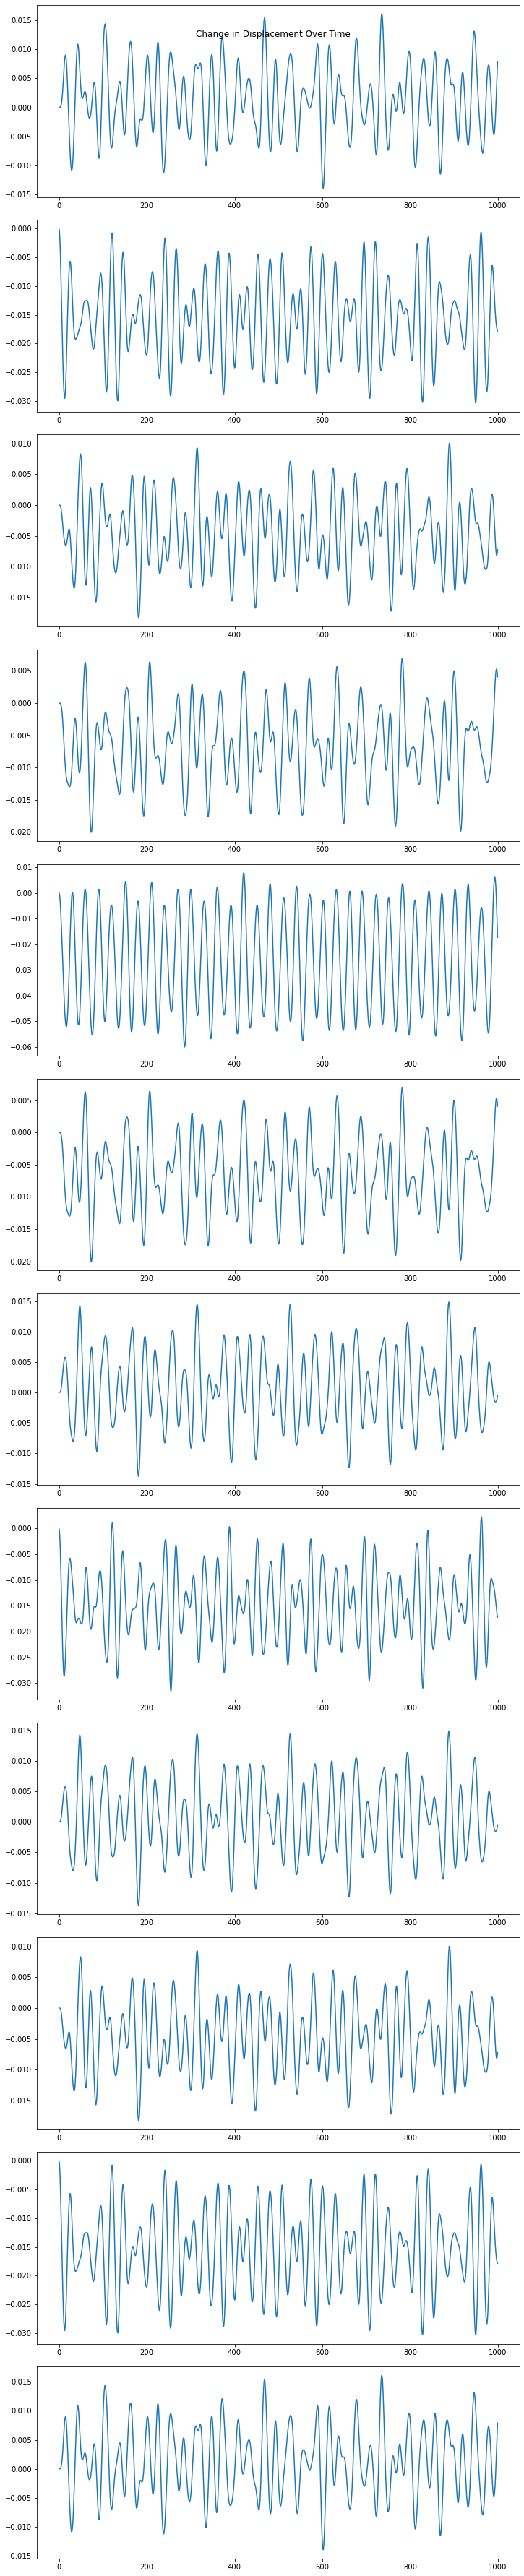

In [47]:
x = [i for i in range(n)]
    
results = np.array(results)
fig, axs = plt.subplots(U.shape[0], figsize=(10,50))
fig.suptitle('Change in Displacement Over Time')
fig.tight_layout()
for i, ax in enumerate(axs):
    ax.plot(x, results[:, i])
plt.show()